# Quality assessment: Ice sheet surface elevation change rate for Greenland and Antarctica from 1992 to present derived from satellite observations

### Use Case: Using the ice sheet surface elevation change time series as an indicator for the ice sheet imbalance in the context of the current global warming

### User Question: How does the consistency and stability of the ice sheet surface elevation change data, aggregated from distinct satellite sensors over time, change and how does it affect estimates of (cumulative) ice sheet-related volume changes?

This script summarizes the scientific quality assessment provided for the C3S_520 service regarding Surface Elevation Change (SEC) data for the Greenland (GrIS) and Antarctic Ice Sheet (AIS) as they are available on the Climate Data Store (CDS) [version 3.0].

## General description

The surface elevation change product quantifies the change of the surface elevation of the ice sheets and in that sense provides volume changes of the ice sheets. Mapping ice sheet surface elevation change and its temporal evolution provides key information for investigating the response of ice sheets to climate change. Remote sensing techniques that use satellite data are the only feasible manner to derive accurate surface elevation changes of the remote ice sheets on a regular basis and on a large spatial scale. Remote sensing devices are able to inspect directly and repeatedly large areas of ice, and, as such are able to examine the surface of the ice sheets. SEC data on the CDS are derived from satellite radar altimetry, followed by filtering, corrections, and (pre/post-)processing. Repeated measurements and the necessary processing of the acquired raw altimetric data transforms this information into surface elevation changes. These techniques, however, also have their limitations of which the user should take note when using the product.

Radar altimeters, in contrast to laser altimeters, provide, for example, measurements in all weather conditions, but in contrast have a much larger footprint which results in a less finer precision of the measurements. This especially provides difficulties around the margins, where complex and high-slope terrain prevails. The radar signal can furthermore penetrate into the snowpack until a certain depth, depending on the properties of the snow layers and the frequency of the sensor. Snow melting allows, for example, for variable snowpack penetration depths of the radar pulse (e.g. due to a changing liquid water content or refrozen ice lenses), hence possibly introducing artificial elevation changes (i.e. for example when the radar pulse is reflected from liquid water within the snowpack). Moreover, surface elevation changes can be thought of as volume changes and hence do not necessarily equal mass changes, because the signal may also comprise effects from changes in the firn layer thickness (densification of firn results in a decrease in surface elevation with no related mass change) and rebound from glacial isostatic adjustment as a response to past and present ice sheet mass changes (i.e. vertical bedrock motions). The conversion of altimetric surface (volume) changes (corrected for the occurrence of non-mass change processes) to actual mass changes can however be performed by assuming that volume changes in ablation areas occur at the density of ice and else at the snow density.

High-quality products are desired to accurately assess and understand the current general state, as well as the climate change impact on the ice sheet. Moreover, data maturity and a high-quality SEC Essential Climate Variable (ECV) are evidently important, for example when serving as input to derive ice sheet mass changes and associated global sea level contribution. The consistency and long temporal extent of the data have made the SEC data suitable for usage in scientific research, for example to derive long-term SEC means, variability and trends (e.g. Sørensen et al., 2018; Schröder et al., 2019), to derive the ice sheet mass changes and the associated contribution to global sea level change (e.g. Shepherd et al., 2019), and even in a decision support system (e.g. Shepherd et al., 2012; Fox-Kemper et al., 2021).

## Setup and retrieval

Here, we will load all packages that are needed to run the code.

In [1]:
import netCDF4 as nc
import cdsapi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import glob
import zipfile
import math
import warnings
from datetime import datetime
from astropy.time import Time
from scipy.stats import linregress
import pwlf
import pymannkendall as mk

#### Set the data request

We set up the data request to download the data from the CDS.

In [4]:
c = cdsapi.Client()

c.retrieve(
    'satellite-ice-sheet-elevation-change',
    {
        'variable': 'all',
        'format': 'zip',
        'domain': [
            'antarctica', 'greenland',
        ],
        'climate_data_record_type': 'icdr',
        'version': '3_0',
    },
    'download.zip')

2023-06-05 15:02:46,759 INFO Welcome to the CDS
2023-06-05 15:02:46,760 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-ice-sheet-elevation-change
2023-06-05 15:02:46,859 INFO Request is completed
2023-06-05 15:02:46,860 INFO Downloading https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data7/dataset-satellite-ice-sheet-elevation-change-3d8ab2f7-90ba-463f-ba33-71ed5e63ebb7.zip to download.zip (46.5M)
2023-06-05 15:02:59,887 INFO Download rate 3.6M/s                               


Result(content_length=48762607,content_type=application/zip,location=https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data7/dataset-satellite-ice-sheet-elevation-change-3d8ab2f7-90ba-463f-ba33-71ed5e63ebb7.zip)

#### Unpack the downloaded data

Now that the data are downloaded, we can extract them out of the NetCDF file.

In [5]:
files = glob.glob('/Users/yoniverhaegen/download.zip')
files
for file in files:
    print('Unzipping:',file)

    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('/Users/yoniverhaegen/')

Unzipping: /Users/yoniverhaegen/download.zip


In [2]:
# Dataset 1 (GrIS)
dataset_gris = nc.Dataset('/Users/yoniverhaegen/C3S_GrIS_RA_SEC_25km_vers3_2023-04-16.nc')
# Dataset 2 (AIS)
dataset_ais = nc.Dataset('/Users/yoniverhaegen/C3S_AntIS_RA_SEC_vers3_2023-01-16.nc')

#### Extract the surface elevation change magnitude

Now we can extract the surface elevation change values and plot their multiyear mean values. These data have units in m/yr.

In [3]:
# Surface elevation changes (m/yr)
# Dataset 1 (GrIS)
sec_mag_gris = dataset_gris['dhdt'][:]
sec_mag_gris.data;
# Dataset 2 (AIS)
sec_mag_ais = dataset_ais['sec'][:]
sec_mag_ais.data;

Let us calculate the spatial distribution of the multiyear mean surface elevation change values:

In [4]:
# Dataset 1 (GrIS)
n = sec_mag_gris.shape
mean_sec_gris = np.zeros((n[0], n[1]))
for i in range(0,n[0]):
    for j in range(0,n[1]):
        sec_point = sec_mag_gris.data[i,j,:]
        warnings.filterwarnings('ignore')
        mean_sec_gris[i,j] = np.nanmean(sec_point);
        warnings.filterwarnings('ignore')
# Dataset 2 (AIS)
n = sec_mag_ais.shape
mean_sec_ais = np.zeros((n[0], n[1]))
for i in range(0,n[0]):
    for j in range(0,n[1]):
        sec_point = sec_mag_ais.data[i,j,:]
        warnings.filterwarnings('ignore')
        mean_sec_ais[i,j] = np.nanmean(sec_point);
        warnings.filterwarnings('ignore')

We can also calculate the temporal evolution of the ice sheet-wide mean surface elevation change:

In [5]:
# Dataset 1 (GrIS)
n = sec_mag_gris.shape
mean_sec_gris_time = np.zeros(n[2])
for i in range(0,n[2]):
    sec_time = sec_mag_gris.data[:,:,i]
    mean_sec_gris_time[i] = np.nanmean(sec_time)
mean_sec_gris_time-mean_sec_gris_time[0];
# Dataset 2 (AIS)
n = sec_mag_ais.shape
mean_sec_ais_time = np.zeros(n[2])
for i in range(0,n[2]):
    sec_time = sec_mag_ais.data[:,:,i]
    mean_sec_ais_time[i] = np.nanmean(sec_time)
mean_sec_ais_time-mean_sec_ais_time[0];

#### We can do the same for the uncertainty

Now we can extract the error values and their spatial distribution.

In [6]:
# Dataset 1 (GrIS)
sec_err_gris = dataset_gris['dhdt_uncert'][:]
sec_err_gris.data;
# Dataset 2 (AIS)
sec_err_ais = dataset_ais['sec_uncert'][:]
sec_err_ais.data;

#### Extract the time variable

Here, we extract the time variable and convert it to decimal years for easy plotting of the time variable on the x-axis

In [7]:
## Dataset 1 (GrIS)
# Extract time variable
time_sec = dataset_gris['time'][:]
time_sec.data;
t_unit = dataset_gris.variables['time'].units
n = len(time_sec)
# Convert this to decimal years
time_convert = nc.num2date(time_sec, t_unit)
date_year = np.zeros(n)
for i in range(0,n):
        time_convert_time=time_convert[i]
        d1_time = int(time_convert_time.strftime('%Y'))
        date_year[i]=d1_time
date_month = np.zeros(n)
for i in range(0,n):
        time_convert_time=time_convert[i]
        d1_time = int(time_convert_time.strftime('%m'))
        date_month[i]=d1_time
date_day = np.zeros(n)
for i in range(0,n):
        time_convert_time=time_convert[i]
        d1_time = int(time_convert_time.strftime('%d'))
        date_day[i]=d1_time
decimal_year = np.zeros(n)
for i in range(0,n):
        input_date =  datetime(int(date_year[i]), int(date_month[i]), int(date_day[i]))
        astropy_time_object = Time(input_date,format='datetime')
        decimal_year[i] = astropy_time_object.decimalyear
decimal_year_gris = decimal_year;
date_month_gris = date_month;
date_year_gris = date_year;
## Dataset 2 (AIS)
# Extract time variable
time_sec = dataset_ais['time'][:]
time_sec.data;
t_unit = dataset_ais.variables['time'].units
n = len(time_sec)
# Convert this to decimal years
time_convert = nc.num2date(time_sec, t_unit)
date_year = np.zeros(n)
for i in range(0,n):
        time_convert_time=time_convert[i]
        d1_time = int(time_convert_time.strftime('%Y'))
        date_year[i]=d1_time
date_month = np.zeros(n)
for i in range(0,n):
        time_convert_time=time_convert[i]
        d1_time = int(time_convert_time.strftime('%m'))
        date_month[i]=d1_time
date_day = np.zeros(n)
for i in range(0,n):
        time_convert_time=time_convert[i]
        d1_time = int(time_convert_time.strftime('%d'))
        date_day[i]=d1_time
decimal_year = np.zeros(n)
for i in range(0,n):
        input_date =  datetime(int(date_year[i]), int(date_month[i]), int(date_day[i]))
        astropy_time_object = Time(input_date,format='datetime')
        decimal_year[i] = astropy_time_object.decimalyear
decimal_year_ais = decimal_year;
date_month_ais = date_month;
date_year_ais = date_year;

#### Extract the land mask

Get the land mask for data completeness analysis.

In [8]:
# Dataset 1 (GrIS)
landmask_gris = dataset_gris['land_mask'][:]
landmask_gris.data;
landmask_gris[np.where(landmask_gris>0)]=1
mask_gris = landmask_gris[np.where(landmask_gris > 0)].sum()
# Dataset 2 (AIS)
landmask_ais = dataset_ais['surface_type'][:]
landmask_ais.data;
landmask_ais[np.where(landmask_ais>0)]=1
mask_ais = landmask_ais[np.where(landmask_ais > 0)].sum()

## Results and discussion

#### We can now finally plot the SEC data 

The surface elevation change data at the ice sheet-wide scale can be plotted as a time series. To do so, no additional processing of the data has been peformed. 

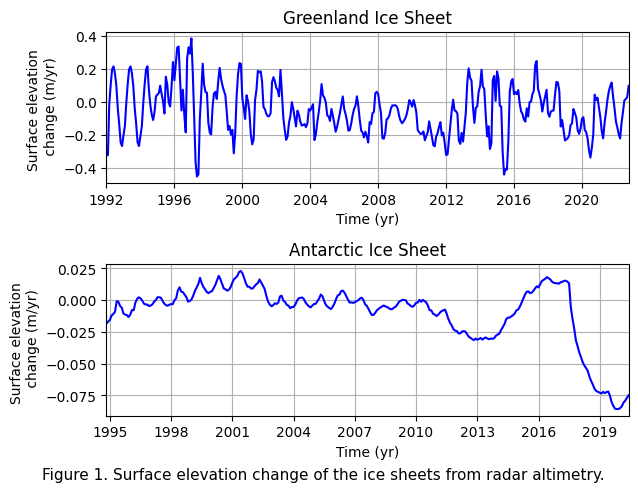

In [9]:
fig=plt.figure()
txt="Figure 1. Surface elevation change of the ice sheets from radar altimetry."
plt.figtext(0.5, -0.01,txt, wrap=True, horizontalalignment='center', fontsize=11)
# GrIS
plt.subplot(2,1,1)
plt.plot(decimal_year_gris, mean_sec_gris_time,color='blue')
plt.ylabel("Surface elevation \n change (m/yr)")
plt.title("Greenland Ice Sheet")
plt.xlabel("Time (yr)")
plt.xticks([1992,1996,2000,2004,2008,2012,2016,2020])
plt.xlim(decimal_year_gris[0], decimal_year_gris[-1])
plt.grid()
# AIS
plt.subplot(2,1,2)
plt.plot(decimal_year_ais, mean_sec_ais_time,color='blue')
plt.ylabel("Surface elevation \n change (m/yr)")
plt.xlabel("Time (yr)")
plt.title("Antarctic Ice Sheet")
plt.xticks([1995,1998,2001,2004,2007,2010,2013,2016,2019,2022])
plt.xlim(decimal_year_ais[0], decimal_year_ais[-1])
plt.grid()
fig.tight_layout()
plt.show()

The SEC time series exhibits data at monthly temporal intervals from various radar altimetry missions since the 1990s, that have been merged into a consistent record. Concerning the GrIS and AIS as a whole, the spatial resolution of 25 km from which the data are derived is too coarse with respect to the expected minimum by GCOS (Global Climate Observing System) (World Meteorological Organization, 2022). The monthly temporal resolution at which the data are provided is, on the other hand, excellent. At last, the spatial distribution of the multiyear mean surface elevation change data is ready to be plotted:

<Figure size 640x480 with 0 Axes>

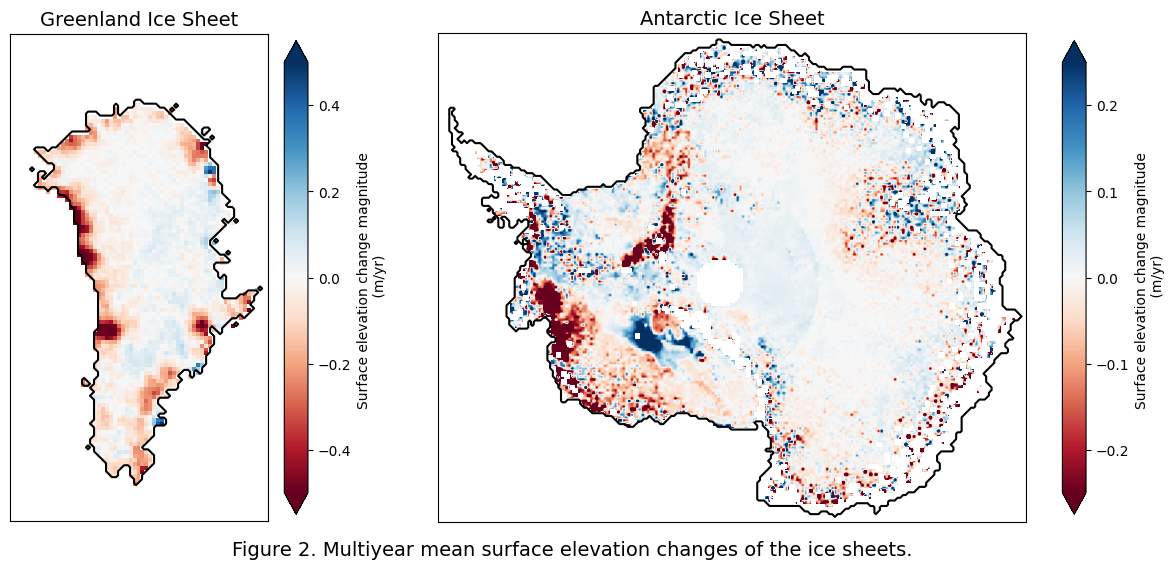

In [561]:
fig=plt.figure()
plt.subplots(1, 2,  figsize=(15, 15), gridspec_kw={'width_ratios': [1, 2.275]});
warnings.filterwarnings('ignore')
txt="Figure 2. Multiyear mean surface elevation changes of the ice sheets."
plt.figtext(0.5, 0.31,txt, wrap=True, horizontalalignment='center', fontsize=14)
# GrIS
plt.subplot(1, 2, 1)
imgplot = plt.imshow(mean_sec_gris, cmap='RdBu')
c = plt.colorbar(extend='both',shrink=0.41)
plt.clim(-.5, .5)
ax = plt.gca()
ax.set_xticks([]);
ax.set_yticks([]);
plt.gca().invert_yaxis()
ax.set_title('Greenland Ice Sheet', fontsize=14)
c.set_label('Surface elevation change magnitude \n (m/yr)')
yc = np.linspace(0, landmask_gris.shape[0], landmask_gris.shape[0])
xc = np.linspace(0, landmask_gris.shape[1], landmask_gris.shape[1])
X, Y = np.meshgrid(xc, yc)
plt.contour(X, Y, landmask_gris,[0.5],colors='black');
# AIS
plt.subplot(1, 2, 2)
imgplot = plt.imshow(mean_sec_ais, cmap='RdBu')
c = plt.colorbar(extend='both',shrink=0.41)
plt.clim(-.25, .25)
ax = plt.gca()
ax.set_xticks([]);
ax.set_yticks([]);
plt.gca().invert_yaxis()
ax.set_title('Antarctic Ice Sheet', fontsize=14)
c.set_label('Surface elevation change magnitude \n (m/yr)')
yc = np.linspace(0, landmask_ais.shape[0], landmask_ais.shape[0])
xc = np.linspace(0, landmask_ais.shape[1], landmask_ais.shape[1])
X, Y = np.meshgrid(xc, yc)
plt.contour(X, Y, landmask_ais,[0.5],colors='black');
fig.tight_layout()

For the GrIS, the average surface elevation changes predominantly show negative values, whereas for the AIS as a whole, the surface elevation changes are relatively less pronounced. When zooming in on some specific areas, it can be seen that the most negative mean value can be found near Jakobshavn Glacier for the GrIS, and near Pine Island Glacier for the AIS. Moreover, the data clearly exhibit a noisy character in some parts of the AIS.

Let us calculate the average surface elevation changes for both ice sheets:

In [229]:
print(f'The average ice sheet-wide surface elevation change of the GrIS during the observed period is {np.mean(mean_sec_gris_time):.4f}','m/yr.')
print(f'The average ice sheet-wide surface elevation change of the AIS during the observed period is {np.mean(mean_sec_ais_time):.4f}','m/yr.')

The average ice sheet-wide surface elevation change of the GrIS during the observed period is -0.0506 m/yr.
The average ice sheet-wide surface elevation change of the AIS during the observed period is -0.0093 m/yr.


From this analysis, it turns out that the average annual change in surface elevation of the AIS is calculated to be lower in magnitude than that of the GrIS, whose surface has been lowering at a higher rate. The negative values indicate that the surfaces of both ice sheets, in general, have been lowering during the last several decades, resulting in net negative values.

#### Let us find out how many temporally missing data are present in the dataset

To do that, we need to find the amount of SEC pixels that are present and plot the resulting time series.

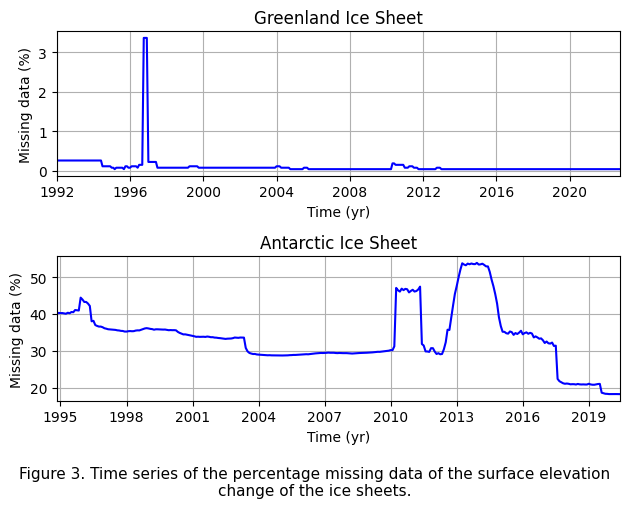

In [11]:
# Dataset 1 (GrIS)
n = sec_mag_gris.shape
missing_data_gris = np.zeros(n[2])
for i in range(0,n[2]):
    sec_time = sec_mag_gris.data[:,:,i]
    land_pixels_gris = np.count_nonzero(~np.isnan(sec_time))
    missing_data_gris[i] = 100*(1-(land_pixels_gris/mask_gris));
# Dataset 2 (AIS)
n = sec_mag_ais.shape
missing_data_ais = np.zeros(n[2])
for i in range(0,n[2]):
    sec_time = sec_mag_ais.data[:,:,i]
    land_pixels_ais = np.count_nonzero(~np.isnan(sec_time))
    missing_data_ais[i] = 100*(1-(land_pixels_ais/mask_ais));
# Plot data
fig=plt.figure()
txt="Figure 3. Time series of the percentage missing data of the surface elevation change of the ice sheets."
plt.figtext(0.5, -0.07,txt, wrap=True, horizontalalignment='center', fontsize=11)
# GrIS
plt.subplot(2,1,1)
plt.plot(decimal_year_gris, missing_data_gris,color='blue')
plt.ylabel("Missing data (%)")
plt.title("Greenland Ice Sheet")
plt.xlabel("Time (yr)")
plt.xticks([1992,1996,2000,2004,2008,2012,2016,2020])
plt.xlim(decimal_year_gris[0], decimal_year_gris[-1])
plt.grid()
# AIS
plt.subplot(2,1,2)
plt.plot(decimal_year_ais, missing_data_ais,color='blue')
plt.ylabel("Missing data (%)")
plt.xlabel("Time (yr)")
plt.title("Antarctic Ice Sheet")
plt.xticks([1995,1998,2001,2004,2007,2010,2013,2016,2019,2022])
plt.xlim(decimal_year_ais[0], decimal_year_ais[-1])
plt.grid()
fig.suptitle('');
fig.tight_layout()
plt.show()

Temporal coverage is excellent for both ice sheets and represents the observational period without data gaps. For the GrIS, most spatial data gaps have been filled and the spatial coverage extends approximately over the entire ice sheet. It, however, does not include peripheral glaciers and ice caps. For the AIS, the main issue concerning missing data pixels are situated around the margins and the polar gap. Here, spatial data gaps are equally not filled. In the beginning of the dataset, the polar gap was rather large, whereas its area has clearly decreased later on due to inclusion of CryoSat-2 and Sentinel-3A data:

<Figure size 640x480 with 0 Axes>

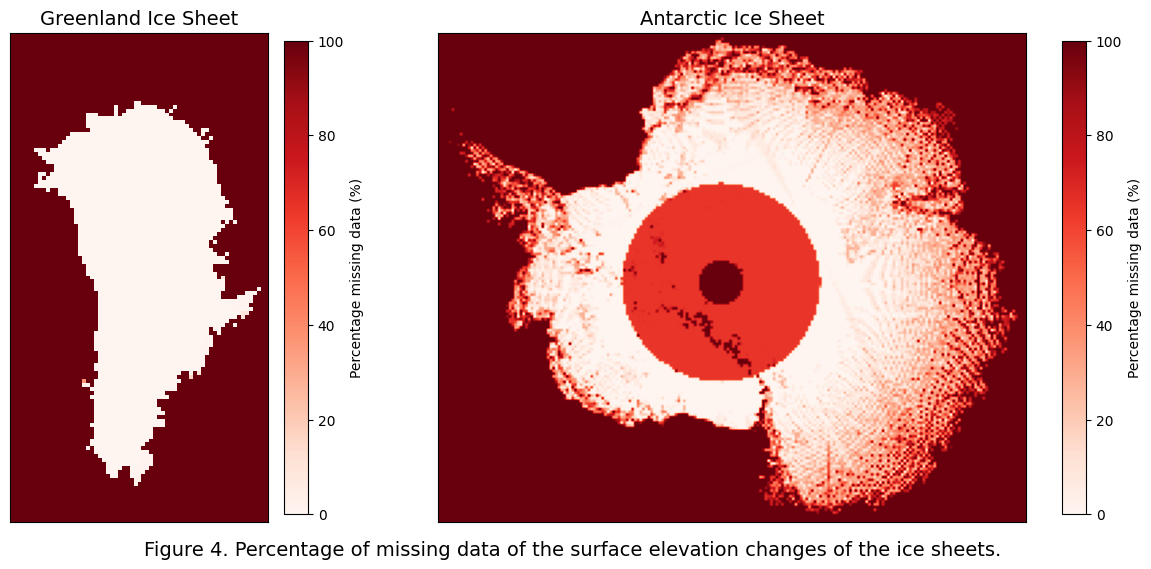

In [564]:
# Dataset 1 (GrIS)
n = sec_mag_gris.shape
missing_data_gris = np.zeros((n[0], n[1]))
for i in range(0,n[0]):
    for j in range(0,n[1]):
        sec_point = sec_mag_gris.data[i,j,:]
        warnings.filterwarnings('ignore')
        land_pixels_gris = np.count_nonzero(~np.isnan(sec_point))
        missing_data_gris[i,j] = 100*(1-(land_pixels_gris/n[2]));
# Dataset 1 (GrIS)
n = sec_mag_ais.shape
missing_data_ais = np.zeros((n[0], n[1]))
for i in range(0,n[0]):
    for j in range(0,n[1]):
        sec_point = sec_mag_ais.data[i,j,:]
        warnings.filterwarnings('ignore')
        land_pixels_ais = np.count_nonzero(~np.isnan(sec_point))
        missing_data_ais[i,j] = 100*(1-(land_pixels_ais/n[2]));

fig=plt.figure()
plt.subplots(1, 2,  figsize=(15, 15), gridspec_kw={'width_ratios': [1, 2.275]});
warnings.filterwarnings('ignore')
txt="Figure 4. Percentage of missing data of the surface elevation changes of the ice sheets."
plt.figtext(0.5, 0.31,txt, wrap=True, horizontalalignment='center', fontsize=14)
# GrIS
plt.subplot(1, 2, 1)
imgplot = plt.imshow(missing_data_gris, cmap='Reds')
c = plt.colorbar(shrink=0.41)
ax = plt.gca()
ax.set_xticks([]);
ax.set_yticks([]);
plt.gca().invert_yaxis()
ax.set_title('Greenland Ice Sheet', fontsize=14)
c.set_label('Percentage missing data (%)')
# AIS
plt.subplot(1, 2, 2)
imgplot = plt.imshow(missing_data_ais, cmap='Reds')
c = plt.colorbar(shrink=0.41)
ax = plt.gca()
ax.set_xticks([]);
ax.set_yticks([]);
plt.gca().invert_yaxis()
ax.set_title('Antarctic Ice Sheet', fontsize=14)
c.set_label('Percentage missing data (%)')
fig.tight_layout()

Let's find out the average amount of missing data:

In [232]:
print('For the GrIS, the average amount of missing data in the SEC dataset is',np.nanmean(missing_data_gris),'%')
print('For the AIS, the average amount of missing data in the SEC dataset is',np.nanmean(missing_data_ais),'%')

For the GrIS, the average amount of missing data in the SEC dataset is 0.1024890190336728 %
For the AIS, the average amount of missing data in the SEC dataset is 33.70874943455589 %


#### At last, we can check whether there are ongoing trends with respect to the surface elevation changes

First, we can check the linear trends and revise whether they are statistically significant with a Mann-Kendall test:

In [532]:
# Perform the analysis
res = linregress(decimal_year_gris, np.cumsum(mean_sec_gris_time))
print(f'The linear trend of the elevation changes of the GrIS during the observed period is {res[0]/12:.4f}','m/yr.')
res = linregress(decimal_year_ais[:-1], np.cumsum(mean_sec_ais_time[:-1]))
print(f'The linear trend of the elevation changes of the AIS during the observed period is {res[0]/12:.4f}','m/yr.')
# Check whether the trend is significant
sign_lvl = 0.05
result = mk.original_test(np.cumsum(mean_sec_gris_time), alpha=sign_lvl)
if result.p < sign_lvl:
    print(f'The obtained linear trend of the elevation changes of the GrIS over time is significant at an alpha level of {sign_lvl}, i.e. a monotonic trend is present.')
else:
    print(f'The obtained linear trend of the elevation changes of the GrIS over time is not significant at an alpha level of {sign_lvl}, i.e. a monotonic trend is not present')
    result = mk.original_test(np.cumsum(mean_sec_ais_time[:-1]), alpha=sign_lvl)
if result.p < sign_lvl:
    print(f'The obtained linear trend of the elevation changes of the AIS over time is significant at an alpha level of {sign_lvl},  i.e. a monotonic trend is present.')
else:
    print(f'The obtained linear trend of the elevation changes of the AIS over time is not significant at an alpha level of {sign_lvl},  i.e. a monotonic trend is not present.')

The linear trend of the elevation changes of the GrIS during the observed period is -0.0591 m/yr.
The linear trend of the elevation changes of the AIS during the observed period is -0.0048 m/yr.
The obtained linear trend of the elevation changes of the GrIS over time is significant at an alpha level of 0.05, i.e. a monotonic trend is present.
The obtained linear trend of the elevation changes of the AIS over time is significant at an alpha level of 0.05,  i.e. a monotonic trend is present.


We can also calculate linear trends for each pixel and hence assess the spatial variability of the trend:

<Figure size 640x480 with 0 Axes>

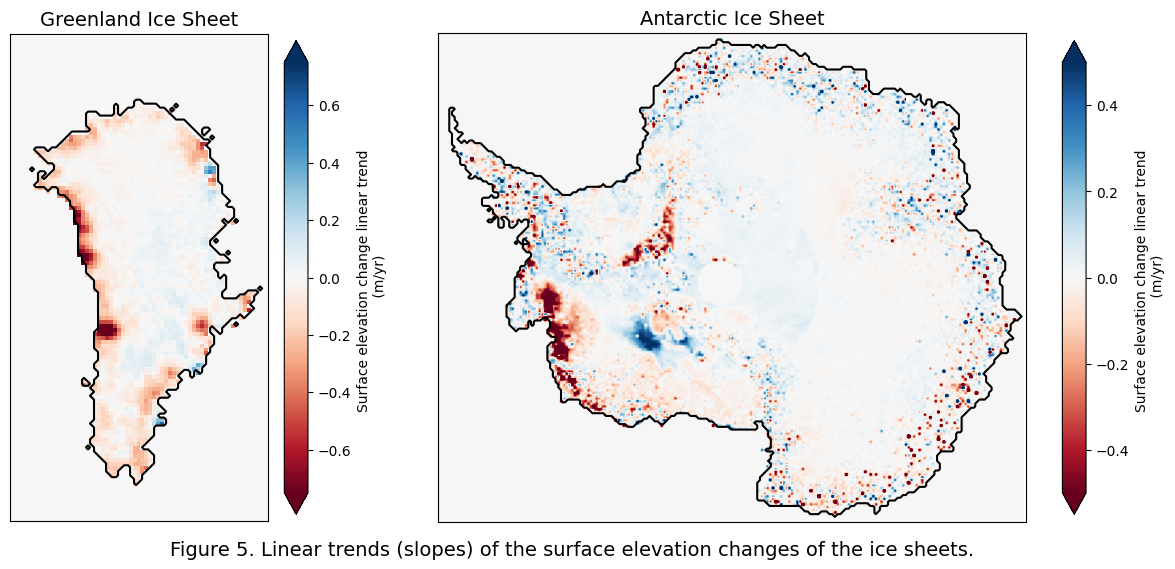

In [533]:
# Dataset 1 (GrIS)
n = sec_mag_gris.shape
lin_trend_sec_gris = np.zeros((n[0], n[1]))
for i in range(0,n[0]):
    for j in range(0,n[1]):
        sec_point = sec_mag_gris.data[i,j,:]/12
        warnings.filterwarnings('ignore')
        mask = ~np.isnan(sec_point)
        if mask.any() == True:
            res = linregress(decimal_year_gris[mask], np.cumsum(sec_point[mask]))
            lin_trend_sec_gris[i,j] = res[0]      
# Dataset 2 (AIS)
n = sec_mag_ais.shape
lin_trend_sec_ais = np.zeros((n[0], n[1]))
for i in range(0,n[0]):
    for j in range(0,n[1]):
        sec_point = sec_mag_ais.data[i,j,:]/12
        warnings.filterwarnings('ignore')
        mask = ~np.isnan(sec_point)
        if mask.any() == True:
            res = linregress(decimal_year_ais[mask], np.cumsum(sec_point[mask]))
            lin_trend_sec_ais[i,j] = res[0]      
fig=plt.figure();
plt.subplots(1, 2,  figsize=(15, 15), gridspec_kw={'width_ratios': [1, 2.275]});
warnings.filterwarnings('ignore')
txt="Figure 5. Linear trends (slopes) of the surface elevation changes of the ice sheets."
plt.figtext(0.5, 0.31,txt, wrap=True, horizontalalignment='center', fontsize=14)
# GrIS
plt.subplot(1, 2, 1);
imgplot = plt.imshow(lin_trend_sec_gris, cmap='RdBu');
c = plt.colorbar(extend='both',shrink=0.41);
plt.clim(-.75,.75);
ax = plt.gca();
ax.set_xticks([]);
ax.set_yticks([]);
plt.gca().invert_yaxis();
ax.set_title('Greenland Ice Sheet', fontsize=14);
c.set_label('Surface elevation change linear trend \n (m/yr)');
yc = np.linspace(0, landmask_gris.shape[0], landmask_gris.shape[0])
xc = np.linspace(0, landmask_gris.shape[1], landmask_gris.shape[1])
X, Y = np.meshgrid(xc, yc)
plt.contour(X, Y, landmask_gris,[0.5],colors='black');
# AIS
plt.subplot(1, 2, 2);
imgplot = plt.imshow(lin_trend_sec_ais, cmap='RdBu');
c = plt.colorbar(extend='both',shrink=0.41);
plt.clim(-0.5,0.5);
ax = plt.gca();
ax.set_xticks([]);
ax.set_yticks([]);
plt.gca().invert_yaxis();
ax.set_title('Antarctic Ice Sheet', fontsize=14);
c.set_label('Surface elevation change linear trend \n (m/yr)');
yc = np.linspace(0, landmask_ais.shape[0], landmask_ais.shape[0])
xc = np.linspace(0, landmask_ais.shape[1], landmask_ais.shape[1])
X, Y = np.meshgrid(xc, yc)
plt.contour(X, Y, landmask_ais,[0.5],colors='black');
fig.tight_layout();
plt.show();
warnings.filterwarnings('ignore')

When assessing the spatial distribution of the linear surface elevation change trends, it can be seen that especially the areas near Jakobshavn Glacier and some other selected outlet glaciers (GrIS) and Pine Island Glacier (AIS) exhibit a clear trend of the surface elevation decline. Large parts of both ice sheets exhibit, however, overall stable conditions with SEC trends around zero m yr^-1, although the pattern is noisy for the AIS due to the large amount of missing data and the lack of spatial filtering of the data.

We can also determine whether there is a quadratic trend (acceleration) of the surface elevation change over the years:

In [268]:
# GrIS
#define variables
gris_trend_x = decimal_year_gris
gris_trend_y = np.cumsum(mean_sec_gris_time)
#polynomial fit with degree = 2
model = np.poly1d(np.polyfit(gris_trend_x, gris_trend_y, 2))
model_gris = model
# AIS
#define variables
ais_trend_x = decimal_year_ais
ais_trend_y = np.cumsum(mean_sec_ais_time)
#polynomial fit with degree = 2
model = np.poly1d(np.polyfit(ais_trend_x, ais_trend_y, 2))
model_ais = model

In [534]:
print(f'The quadratic trend of the annual ice sheet-wide surface elevation change of the GrIS during {date_year_gris[0]:.0f}-{date_year_gris[-1]:.0f} is {2*model_gris.coeffs[0]/12:.5f}','m/yr^2')
print(f'The quadratic trend of the annual ice sheet-wide surface elevation change of the AIS during {date_year_ais[0]:.0f}-{date_year_ais[-1]:.0f} is {2*model_ais.coeffs[0]/12:.5f}','m/yr^2')

The trend of the annual ice sheet-wide surface elevation change of the GrIS during 1992-2022 is -0.00395 m/yr^2
The trend of the annual ice sheet-wide surface elevation change of the AIS during 1994-2020 is -0.00149 m/yr^2


As with the linear trend, we can also calculate quadratic trends for each pixel and hence assess the spatial variability of the acceleration:

<Figure size 640x480 with 0 Axes>

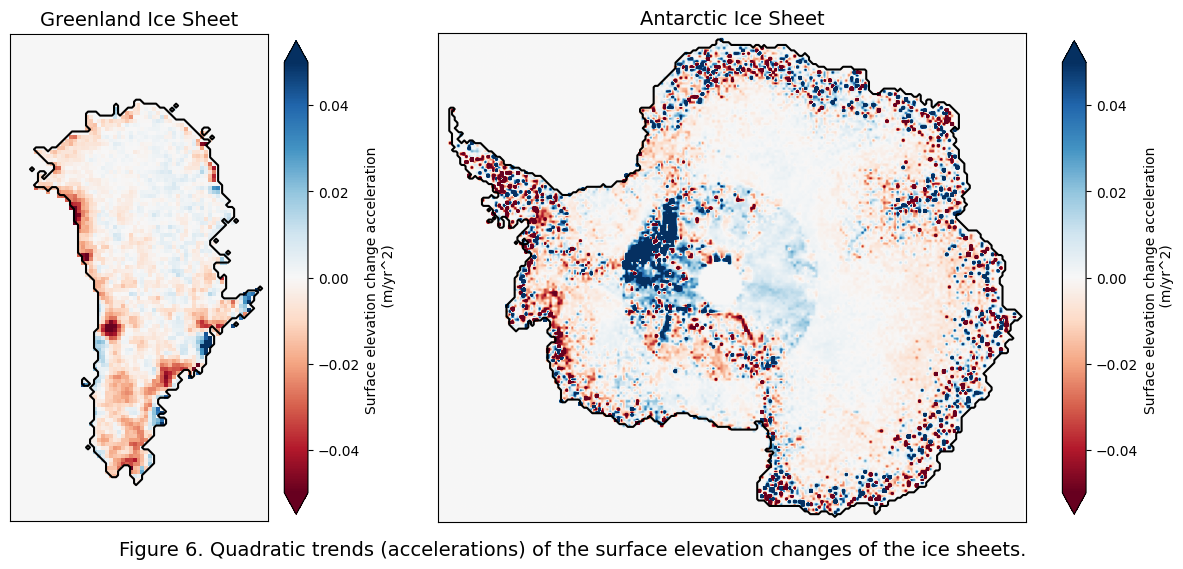

In [535]:
# Dataset 1 (GrIS)
n = sec_mag_gris.shape
qua_trend_sec_gris = np.zeros((n[0], n[1]))
for i in range(0,n[0]):
    for j in range(0,n[1]):
        sec_point = sec_mag_gris.data[i,j,:]
        warnings.filterwarnings('ignore')
        mask = ~np.isnan(sec_point)
        if mask.any() == True:
            model = np.poly1d(np.polyfit(decimal_year_gris[mask], np.cumsum(sec_point[mask]), 2))
            qua_trend_sec_gris[i,j] = 2*model.coeffs[0]    
# Dataset 2 (AIS)
n = sec_mag_ais.shape
qua_trend_sec_ais = np.zeros((n[0], n[1]))
for i in range(0,n[0]):
    for j in range(0,n[1]):
        sec_point = sec_mag_ais.data[i,j,:]
        warnings.filterwarnings('ignore')
        mask = ~np.isnan(sec_point)
        if mask.any() == True:
            model = np.poly1d(np.polyfit(decimal_year_ais[mask], np.cumsum(sec_point[mask]), 2))
            qua_trend_sec_ais[i,j] = 2*model.coeffs[0]    
fig=plt.figure()
plt.subplots(1, 2,  figsize=(15, 15), gridspec_kw={'width_ratios': [1, 2.275]});
warnings.filterwarnings('ignore')
txt="Figure 6. Quadratic trends (accelerations) of the surface elevation changes of the ice sheets."
plt.figtext(0.5, 0.31,txt, wrap=True, horizontalalignment='center', fontsize=14)
# GrIS
plt.subplot(1, 2, 1)
imgplot = plt.imshow(qua_trend_sec_gris/12, cmap='RdBu')
c = plt.colorbar(extend='both',shrink=0.41)
plt.clim(-.05, .05)
ax = plt.gca()
ax.set_xticks([]);
ax.set_yticks([]);
plt.gca().invert_yaxis()
ax.set_title('Greenland Ice Sheet', fontsize=14)
c.set_label('Surface elevation change acceleration \n (m/yr^2)')
yc = np.linspace(0, landmask_gris.shape[0], landmask_gris.shape[0])
xc = np.linspace(0, landmask_gris.shape[1], landmask_gris.shape[1])
X, Y = np.meshgrid(xc, yc)
plt.contour(X, Y, landmask_gris,[0.5],colors='black');
fig.tight_layout()
# AIS
plt.subplot(1, 2, 2)
imgplot = plt.imshow(qua_trend_sec_ais/12, cmap='RdBu')
c = plt.colorbar(extend='both',shrink=0.41)
plt.clim(-.05, .05)
ax = plt.gca()
ax.set_xticks([]);
ax.set_yticks([]);
plt.gca().invert_yaxis()
ax.set_title('Antarctic Ice Sheet', fontsize=14)
c.set_label('Surface elevation change acceleration \n (m/yr^2)')
yc = np.linspace(0, landmask_ais.shape[0], landmask_ais.shape[0])
xc = np.linspace(0, landmask_ais.shape[1], landmask_ais.shape[1])
X, Y = np.meshgrid(xc, yc)
plt.contour(X, Y, landmask_ais,[0.5],colors='black');
fig.tight_layout()
plt.show();
warnings.filterwarnings('ignore')

When assessing the spatial distribution of the surface elevation change trends, it can be seen that especially the areas near Jakobshavn Glacier and some other selected outlet glaciers (GrIS) and Pine Island Glacier (AIS) exhibit an acceleration of the surface elevation decline. Large parts of both ice sheets exhibit, however, overall stable conditions with SEC acceleration trends around zero m/yr^2, although the pattern is again noisy for the AIS due to the large amount of missing data and lack of spatial filtering procedures.

Let us take an example and calculate the trends for an individual pixel, the Jakobshavn Glacier of the GrIS. This area has the most pronounced surface elevation changes across the whole ice sheet:

Equation linear trend: -0.739 * x + 1475.092, the slope is -0.739 m/yr.
Equation quadratic trend: -0.023 * x^2 + 92.822 * x + -92428.245, the acceleration is -0.047 m/yr^2.


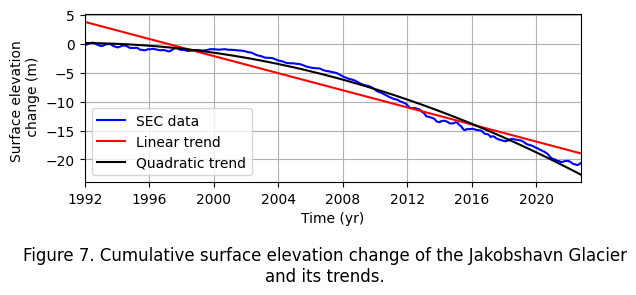

In [13]:
# Select the Jakobshavn Glacier pixel
Jakobshavn_glacier = sec_mag_gris.data[48,26,:]/12
# Calculate the linear trend
res = linregress(decimal_year_gris, np.cumsum(sec_mag_gris.data[48,26,:]/12))
print(f'Equation linear trend: {res[0]:.3f} * x + {res[1]:.3f}, the slope is {res[0]:.3f} m/yr.')
# Calculate the quadratic trend
model = np.poly1d(np.polyfit(decimal_year_gris, np.cumsum(sec_mag_gris.data[48,26,:]/12), 2))
print(f'Equation quadratic trend: {model[2]:.3f} * x^2 + {model[1]:.3f} * x + {model[0]:.3f}, the acceleration is {2*model[2]:.3f} m/yr^2.')

# Plot data
fig=plt.figure()
txt="Figure 7. Cumulative surface elevation change of the Jakobshavn Glacier and its trends."
plt.figtext(0.5, 0.33,txt, wrap=True, horizontalalignment='center', fontsize=12)
# GrIS
plt.subplot(2,1,1)
plt.plot(decimal_year_gris, np.cumsum(Jakobshavn_glacier),color='blue', label='SEC data')
plt.plot(decimal_year_gris, res.intercept + res.slope*decimal_year_gris, 'r', label='Linear trend')
plt.plot(decimal_year_gris, model(decimal_year_gris), 'k', label='Quadratic trend')
plt.ylabel("Surface elevation \n change (m)")
#plt.title("Cumulative surface elevation change of the Jakobshavn Glacier")
plt.xlabel("Time (yr)")
plt.xticks([1992,1996,2000,2004,2008,2012,2016,2020])
plt.xlim(decimal_year_gris[0], decimal_year_gris[-1])
plt.grid()
plt.legend(loc='lower left');

# Conclusion

#### Key strengths and key weaknesses

<u>Key strengths</u>:

• The data have no temporal gaps, have a long temporal extent since 1992 and are found to be suitable to derive mean values, variability and trends (climate change signals).<br>
• Data include quantitative error and uncertainty characterization measures in the form of gridded errors, validity flag maps and slope class masks.<br>
• The temporal resolution, the average accuracy (for the GrIS), and the number of observations all satisfy the minimum or the optimum GCOS requirements (World Meteorological Organization, 2022).<br>
• There is an abundant amount of guidance or help documents freely and publicly available. Contact information is also provided.<br>
• The data files are accompanied by extensive metadata that meet international standards and provide the user with additional information.<br>
• The guidance documents are regularly updated and include feedback. References to scientific peer-reviewed literature are also provided.<br>
• Data have been used in peer-reviewed research and decision support systems (e.g. Sørensen et al., 2018; Schröder et al., 2019; Fox-Kemper et al., 2021).<br>

<u>Key weaknesses</u>:

• The spatial resolution is too coarse (25 km) with respect to the GCOS requirements (World Meteorological Organization, 2022).<br>
• The GrIS file lacks data for the peripheral glaciers and ice caps, and misssing spatial data on the
main ice sheet have been filled up. The AIS file contains more spatially missing data, due
to the large polar gap and unfilled spatial data gaps (especially around the margins).<br>
• The AIS SEC products seem to be of slightly lower quality than their GrIS counterpart (i.e. a
larger polar gap, more left-over unfilled spatial data gaps, more noisy data, and overall higher standard error and uncertainty values that do not meet the GCOS requirement of 0.1 m yr^-1).<br>
• Data around the margins and in complex terrain (high slope and ablation areas) of the ice sheets are especially sensitive to errors, with slightly lower quality data in these areas.<br>
• Data represent ice sheet surface elevation (i.e. volume) changes. If mass change data are required, SEC data need to be at first corrected for non-mass change processes (e.g. firn densification and vertical bed motion) and converted to mass change using appropriate density values.<br>

#### Take-home messages

Surface elevation change detection by radar altimetry is a useful tool to grasp the impact of climate change on the ice sheets. The dataset, however, also has its limitations of which the user should take note before using the product. For example, the spatial coverage for the AIS data is less extensive due to the larger polar gap and due to the fact that spatial data gaps have not been filled, in contrast to the GrIS SEC data. Furthermore, the AIS data contains more noisy data and also exhibit a smaller temporal extent of the SEC data when compared to the GrIS SEC data. The AIS SEC product also has higher standard error values, which are not at the minimum GCOS requirements (World Meteorological Organization, 2022). The AIS SEC product therefore seems to be of slightly lower quality than its GrIS counterpart. An important limitation of both ice sheets is the relatively coarse spatial resolution of 25 km, which likewise is not at its optimal GCOS requirement (World Meteorological Organization, 2022).

When using the SEC data, users should, however, be aware of the typical problem areas for radar altimetry-derived SEC products. Consulting the accompanying uncertainty measures, for example the standard error, is therefore recommended to assess the error and accuracy characterization of the product. It follows that especially the ice sheet margins contain slightly lower quality data due to the presence of complex terrain, with an increased risk of high-slope errors, potentially blocked signals and the presence of rapidly changing surface conditions such rapidly flowing glaciers or the seasonal cycle of melt/runoff and accumulation. Here, snow melting allows, for example, for variable snowpack penetration depths of the radar pulse (e.g. due to a changing liquid water content or refrozen ice lenses), hence possibly introducing artificial elevation changes. In these areas, relatively higher standard errors can therefore be found.

The ice-sheet wide SEC products are at this stage found to be suitable to derive mean, variability and trends (climate change signals), as (1) the amount of missing data is relatively limited (especially for the GrIS), (2) the temporal resolution is consistent at a monthly basis, and (3) the number of consecutive years is sufficient to filter out inter- and intra-annual variability. When using the product, users should, for proper interpretation, also keep in mind that also other processes besides surface melt and accumulation may contribute to surface height change (e.g. dynamic processes, bed processes, compaction/densification processes, isostatic adjustment, tidal regimes, etc.), and that surface elevation changes do not necessarily equal mass changes.

# References

Fox-Kemper, B., H.T. Hewitt, C. Xiao, G. Aðalgeirsdóttir, S.S. Drijfhout, T.L. Edwards, N.R. Golledge, M. Hemer, R.E. Kopp, G. Krinner, A. Mix, D. Notz, S. Nowicki, I.S. Nurhati, L. Ruiz, J.-B. Sallée, A.B.A. Slangen, and Y. Yu (2021). Ocean, Cryosphere and Sea Level Change. In Climate Change 2021: The Physical Science Basis. Contribution of Working Group I to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change [Masson-Delmotte, V., P. Zhai, A. Pirani, S.L. Connors, C. Péan, S. Berger, N. Caud, Y. Chen, L. Goldfarb, M.I. Gomis, M. Huang, K. Leitzell, E. Lonnoy, J.B.R. Matthews, T.K. Maycock, T. Waterfield, O. Yelekçi, R. Yu, and B. Zhou (eds.)]. Cambridge University Press, Cambridge, United Kingdom and New York, NY, USA, pp. 1211–1362, https://doi.org/110.1017/9781009157896.011.

Schröder, L., Horwath, M., Dietrich, R., Helm, V., van den Broeke, M.R., and Ligtenberg, S.R.M.
(2019). Four decades of Antarctic surface elevation change from multi-mission satellite altimetry.
The Cryosphere, 13, p. 427-449. https://doi.org/10.5194/tc-13-427-2019.

Shepherd, A., Ivins, E.R. Barletta, V.R., Bentley, M.J,, Bettadpur, S., Briggs, K.H., Bromwich, D.H.,
Forsberg, R., Galin, N., Horwath, M., Jacobs, S., Joughin, I., King, M.A., Lenaerts, J.T., Li, J.,
Ligtenberg, S.R., Luckman, A., Luthcke, S.B., McMillan, M., Meister, R., Milne, G., Mouginot, J.,
Muir, A., Nicolas, J.P., Paden, J., Payne, A.J., Pritchard, H., Rignot, E., Rott, H., Sørensen, L.S.,
Scambos, T.A., Scheuchl, B., Schrama, E.J., Smith, B., Sundal, A.V., van Angelen, J.H., van de Berg
W.J., van den Broeke, M.R., Vaughan, D.G., Velicogna, I., Wahr, J., Whitehouse, P.L., Wingham,
D.J., Yi, D., Young, D., Zwally, H.J. (2012). A Reconciled Estimate of Ice-Sheet Mass Balance.
Science, 338 (6111). https://doi.org/10.1126/science.1228102.

Shepherd, A., Gilbert, L., Muir, A.S., Konrad, H., McMillan, M., Slater, T., Briggs, H.K., Sundal, A.
V., Hogg A.E., and Engdahl, M.E. (2019). Trends in Antarctic Ice Sheet elevation and mass.
Geophysical Research Letters, 46, p. 8174-8183. https://doi.org/10.1029/2019GL082182.

Sørensen, L.S., Simonsen, L., Sebastian, B., Forsberg, R., Khvorostovsky, K., Meister, R., and
Engdahl, M. E. (2018). 25 years of elevation changes of the Greenland Ice Sheet from ERS, Envisat,
and CryoSat-2 radar altimetry, Earth and Planetary Science Letters. 495.
https://doi.org/10.1016/j.epsl.2018.05.015.

World Meteorological Organization (2022). The 2022 GCOS ECVs Requirements (GCOS-245). World Meteorological Organization: Geneva, Switzerland. 